In [1]:
# ----------------------------------------------------------------
# IoT Netprofiler
# Licensed under The MIT License [see LICENSE for details]
# Written by Luca Maiano - https://www.linkedin.com/in/lucamaiano/
# ----------------------------------------------------------------

# Attack Detection

In this notebook we apply *learning algorithms* with the aim of detect attacks in an IoT network as accurately as possible. Particularly, we will focus on **supervised** and **unsupervised** algorithms. With this analysis, we want to compare the effectiveness of the following algorithms:
1. K-Nearest Neighbor (KNN)
2. Random Forests Classifier
3. Support Vector Machines (SVM)
5. Deep Neural Network Classifier 
6. K-Means

All mentioned algorithms have been extensively used by *state of the art* solutions in order to solve **anomaly-detection** problems [2].

## Metrics Identification

Using the same approach of Yavuz et al. [1], in order to deal with an imbalanced dataset we use AUC-ROC together with the following metrics:
1. 
$
\begin{align}
Precision = \frac{TP}{TP+FP}
\end{align}
$

2. 
$
\begin{align}
Recall = \frac{TP}{TP+FN}
\end{align}
$

3. 
$
\begin{align}
F1 = 2\frac{precision * recall}{precision+recall}
\end{align}
$
4. AUC-ROC. 

If the AUC-ROC is bigger than 0.5, it means that the model is better than random guessing.




In [1]:
import csv
import pandas as pd
import numpy as np
import sys, os

import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from lib.utils import trace_processing
from lib.visualization import data_visualization
from lib.analysis import trace_statistics
from lib.analysis import trace_classification


Using TensorFlow backend.


Let us start importing 2 sets of experiments:
1. *9 nodes* examples containing grids and random topologies;
2. *16 nodes* examples containing grids and random topologies.

In [2]:
exp_9_nodes = trace_processing.import_trace('data/experiments/cooja3-9nodes/traces/', 'traces.csv')
exp_16_nodes = trace_processing.import_trace('data/experiments/cooja3-16nodes/traces/', 'traces.csv')

experiments = exp_9_nodes + exp_16_nodes

# Experiment 1: Attacked vs Normal Behaviour

Now we import *features* and *normalize* the data to speedup the learning process. For this experiment, we consider just two classes:
1. **Normal** behaviour (0) meaning that the entire network is not under attack;
2. **Attacked** (1), i.e. an attack has been performed (Black Hole or Gray Hole).

In [3]:
data = None
n_classes = 2

for experiment in experiments:
    label = 0
    topology = experiment[0].split('/')[2].split('cooja3-')[1]
    experiment_id = topology + '/' + experiment[1]
    
    if n_classes == 2:
        # Assign a label
        if experiment[1].find('gh') >= 0 or experiment[1].find('bh') >= 0:
            label = 1
    else:
        # Assign a label
        if experiment[1].find('gh') >= 0:
            label = 1
        elif experiment[1].find('bh') >= 0:
            label = 2
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    
    if data is None:
        data = trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)    
    else:
        data = pd.concat([data, trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)])

data = data.sample(frac=1).reset_index(drop=True)
norm_data = trace_processing.feature_normalization(data, ['node', 'experiment', 'label'])
norm_data.head(5)

/Users/lucamaiano/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,node,experiment,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers,label
0,aaaa::212:740e:e:e0e:,16nodes/grid_normal_2019-02-26_10:29_,0.925548,0.786802,0.865296,0.227836,1.00,0.892245,0.933047,0.213198,0.4375,0
1,aaaa::212:740e:e:e0e:,16nodes/grid_1gh50-7_2019-02-19_22:53_,0.920130,0.837563,0.740827,0.239963,1.00,0.759164,0.776050,0.162437,0.6250,1
2,aaaa::212:7403:3:303:,16nodes/grid_1gh50-9_2019-02-19_23:54_,0.536411,0.695431,0.217282,0.234680,0.00,0.154782,0.365774,0.304569,0.3750,1
3,aaaa::212:7410:10:1010:,16nodes/grid_1bh-7_2019-02-19_22:13_,0.752495,0.720812,0.653086,0.117676,0.75,0.744139,0.703750,0.279188,0.4375,1
4,aaaa::212:7404:4:404:,16nodes/grid_normal_2019-02-19_21:23_,0.597849,0.700508,0.348500,0.550685,0.00,0.136392,0.657256,0.299492,0.4375,0


Now we can split the dataset in *training and testing set* of size 80% and 20% respectively.

In [4]:
X = norm_data.drop(['node', 'experiment', 'label'], axis=1)
y = norm_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

X.head()

,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers
0,0.925548,0.786802,0.865296,0.227836,1.00,0.892245,0.933047,0.213198,0.4375
1,0.920130,0.837563,0.740827,0.239963,1.00,0.759164,0.776050,0.162437,0.6250
2,0.536411,0.695431,0.217282,0.234680,0.00,0.154782,0.365774,0.304569,0.3750
3,0.752495,0.720812,0.653086,0.117676,0.75,0.744139,0.703750,0.279188,0.4375
4,0.597849,0.700508,0.348500,0.550685,0.00,0.136392,0.657256,0.299492,0.4375


## Feature Selection

Starting from the results that we obtained during the data exploration phase, we can now start to train and compare the learning algorithms. The results will be compared with different sets of features. Features will be iteratively selected removing the most relevant and less relevant feature. Most significant feature is dropped to avoid *overfitting*, less relevant feature is dropped to avoid *underfitting*.

The experiment will be repeated iteratively following this way:
1. select a set of feature;
2. run learning algorithms;
3. measure performances.

At the end the best set of features will be selected. We start selecting the entire set of features.

### Supervised Algorithms

1. The first algorithm that we evaluate is **k-NN**.

In [5]:
knn_pred = trace_classification.k_nn_classifier(X_train, y_train, X_test, y_test, n_neighbors=3, cross_val=5)
knn_results, knn_confusion_matrix = trace_classification.test_metrics('knn', y_test, knn_pred)
knn_results

AUC on validation set 1/5: 0.7303921568627452
AUC on validation set 2/5: 0.7313725490196079
AUC on validation set 3/5: 0.6617647058823529
AUC on validation set 4/5: 0.6418988648090815
AUC on validation set 5/5: 0.6780185758513932
Mean AUC 0.689 (Std +/- 0.036)


,model,accuracy,precision,recall,f1-score,auc roc
0,knn,0.730337,0.681004,0.681004,0.681004,0.681004


2. Now we evaluate **RandomForest Classifier**.

In [6]:
rfc_pred = trace_classification.random_forest_classifier(X_train, y_train, X_test, y_test, n_estimators=100, cross_val=5)
rfc_results, rfc_confusion_matrix = trace_classification.test_metrics('random forest', y_test, rfc_pred)
rfc_results

AUC on validation set 1/5: 0.5955882352941176
AUC on validation set 2/5: 0.6955882352941176
AUC on validation set 3/5: 0.617156862745098
AUC on validation set 4/5: 0.6186790505675954
AUC on validation set 5/5: 0.714138286893705
Mean AUC 0.714 (Std +/- 0.000)


,model,accuracy,precision,recall,f1-score,auc roc
0,random forest,0.719101,0.660787,0.641577,0.647999,0.641577


3. Prediction of **Support Vector Machines (SVM)**.

In [7]:
svm_pred = trace_classification.svm_classifier(X_train, y_train, X_test, y_test, kernel='linear', cross_val=5)
svm_results, svm_confusion_matrix = trace_classification.test_metrics('svm', y_test, svm_pred)
svm_results

AUC on validation set 1/5: 0.5
AUC on validation set 2/5: 0.5
AUC on validation set 3/5: 0.5
AUC on validation set 4/5: 0.5
AUC on validation set 5/5: 0.5
Mean AUC 0.500 (Std +/- 0.000)


/Users/lucamaiano/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lucamaiano/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,model,accuracy,precision,recall,f1-score,auc roc
0,svm,0.696629,0.348315,0.5,0.410596,0.5


4. Finally we implement **Deep Neural Networks**.

Mean Accuracy: 81.28% (5.55%)


,model,accuracy,precision,recall,f1-score,auc roc
0,neural network,0.831461,0.902597,0.722222,0.753735,0.722222


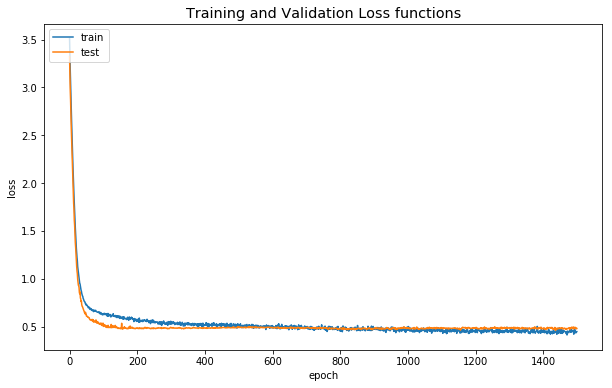

In [8]:
nn_pred = trace_classification.neural_net_classifier(X_train, y_train, X_test, y_test, '2classes')
nn_results, nn_confusion_matrix = trace_classification.test_metrics('neural network', y_test, nn_pred)
nn_results

### Unsupervised Algorithms

Now we can try to model the problem as an unsupervised learning problem. First, we apply a PCA transformation to collapse the set of datapoints to a 3D space.

In [9]:
X_pca = trace_classification.pca_transformation(X, n_components=len(X.columns)-2)
X_pca.head()

,0,1,2,3,4,5,6
0,0.812034,-0.529557,0.136023,-0.094925,0.054229,-0.028909,-0.009181
1,0.585405,-0.570331,0.067953,0.078004,0.156035,-0.008804,-0.006416
2,-0.398465,0.456901,0.027045,-0.025535,0.007498,-0.015796,0.000689
3,0.491950,-0.234459,-0.043878,-0.034347,-0.020611,-0.060979,0.009184
4,-0.229199,0.446381,0.423604,0.006632,0.159292,-0.015643,-0.002505


5. Let us try modeling the problem with **K-Means**.

,model,accuracy,precision,recall,f1-score,auc roc
0,kmeans,0.624434,0.60027,0.62188,0.593462,0.62188


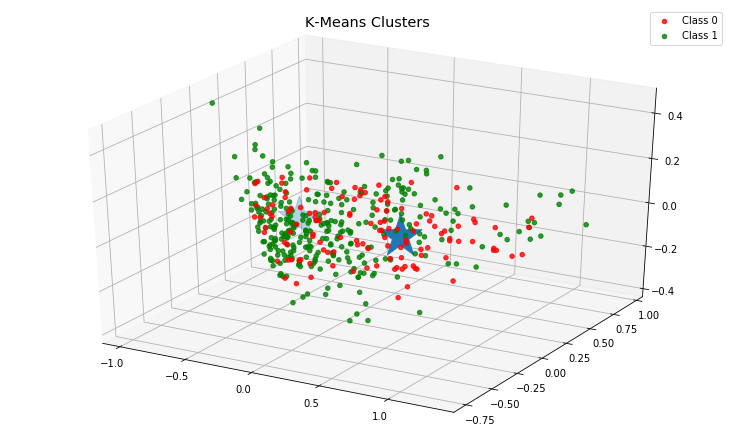

In [10]:
kmeans_pred, centroids = trace_classification.kmeans_classifier(X_pca, n_clusters=2)
data_visualization.plot_3d_points(X_pca[0], X_pca[1], X_pca[3], y, plot_name='KMeans_K2', centroids=centroids)
kmeans_results, kmeans_confusion_matrix = trace_classification.test_metrics('kmeans', y, kmeans_pred)
kmeans_results

## Conclusions

Let us compare the results obtained from the experiment.

In [11]:
trace_classification.write_results([knn_results, rfc_results, svm_results, nn_results, kmeans_results], list(X.columns.values), 2)

,model,n_classes,accuracy,precision,recall,f1-score,auc roc,features
0,knn,2,0.730337,0.681004,0.681004,0.681004,0.681004,"hop, loss, max, mean, min, outliers, pckt_coun..."
1,random forest,2,0.719101,0.660787,0.641577,0.647999,0.641577,"hop, loss, max, mean, min, outliers, pckt_coun..."
2,svm,2,0.696629,0.348315,0.500000,0.410596,0.500000,"hop, loss, max, mean, min, outliers, pckt_coun..."
3,neural network,2,0.831461,0.902597,0.722222,0.753735,0.722222,"hop, loss, max, mean, min, outliers, pckt_coun..."
4,kmeans,2,0.624434,0.600270,0.621880,0.593462,0.621880,"hop, loss, max, mean, min, outliers, pckt_coun..."


Based on the table above, we see that the **neural network** outperform all the other models. **KNN** also achieve really good results follwed by *random forsests*.

# Experiment 2: Normal Behaviour vs Grey Hole vs Black Hole Attack

For this second scenario, we want to detect which attack has been performed (if any). Each node will be labeled as follows:
1. **Normal** behaviour (0) meaning that the entire network is not under attack;
2. **Grey Hole** (1);
3. **Black Hole** (2).

In [12]:
data = None
n_classes = 3

for experiment in experiments:
    label = 0
    topology = experiment[0].split('/')[2].split('cooja3-')[1]
    experiment_id = topology + '/' + experiment[1]
    
    if n_classes == 2:
        # Assign a label
        if experiment[1].find('gh') >= 0 or experiment[1].find('bh') >= 0:
            label = 1
    else:
        # Assign a label
        if experiment[1].find('gh') >= 0:
            label = 1
        elif experiment[1].find('bh') >= 0:
            label = 2
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    
    if data is None:
        data = trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)    
    else:
        data = pd.concat([data, trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)])

data = data.sample(frac=1).reset_index(drop=True)
norm_data = trace_processing.feature_normalization(data, ['node', 'experiment', 'label'])

# Normalize data
X = norm_data.drop(['node', 'experiment', 'label'], axis=1)
y = norm_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

norm_data.head()

/Users/lucamaiano/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,node,experiment,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers,label
0,aaaa::212:7403:3:303:,16nodes/grid_1gh30-9_2019-02-20_00:12_,0.693166,0.934010,0.168158,0.134531,0.00,0.140666,0.249259,0.065990,0.5625,1
1,aaaa::212:7404:4:404:,9nodes/grid9_normal_2019-02-13_17:05_,0.672688,0.700508,0.519302,0.359192,0.25,0.471519,0.606865,0.299492,0.5625,0
2,aaaa::212:7404:4:404:,9nodes/grid9_1bh-5_2019-02-13_15:31_,0.701572,0.807107,0.373064,0.356482,0.25,0.294604,0.540642,0.192893,0.3750,2
3,aaaa::212:7402:2:202:,9nodes/grid9_1bh-6_2019-02-13_19:15_,0.775842,0.984772,0.241301,0.056364,0.25,0.304411,0.251316,0.015228,0.5625,2
4,aaaa::212:740b:b:b0b:,16nodes/grid_normal_2019-02-26_10:29_,0.763657,0.685279,0.765573,0.347470,0.75,0.728371,0.839155,0.314721,0.3750,0


## Feature Selection

We repeat the experiment following the same identical approach as before. Thus we choose a set of features, and we iterate removing the most important and less importan one until we obtain the best results.

### Supervised Algorithms

1. The first algorithm that we evaluate is **k-NN**.

In [13]:
knn_pred = trace_classification.k_nn_classifier(X_train, y_train, X_test, y_test, n_neighbors=3, cross_val=5)
knn_results, knn_confusion_matrix = trace_classification.test_metrics('knn', y_test, knn_pred)
knn_results

AUC on validation set 1/5: 0.5855742296918767
AUC on validation set 2/5: 0.5952705472432875
AUC on validation set 3/5: 0.6635516898096497
AUC on validation set 4/5: 0.623577617197706
AUC on validation set 5/5: 0.6616975335129847
Mean AUC 0.626 (Std +/- 0.032)


,model,accuracy,precision,recall,f1-score,auc roc
0,knn,0.494382,0.496991,0.503968,0.49542,0.625899


2. Now we evaluate **RandomForest Classifier**.

In [14]:
rfc_pred = trace_classification.random_forest_classifier(X_train, y_train, X_test, y_test, n_estimators=100, cross_val=5)
rfc_results, rfc_confusion_matrix = trace_classification.test_metrics('random forest', y_test, rfc_pred)
rfc_results

AUC on validation set 1/5: 0.6816526610644257
AUC on validation set 2/5: 0.631424927694655
AUC on validation set 3/5: 0.746689247047291
AUC on validation set 4/5: 0.6495491552382097
AUC on validation set 5/5: 0.6908501780302814
Mean AUC 0.691 (Std +/- 0.000)


,model,accuracy,precision,recall,f1-score,auc roc
0,random forest,0.516854,0.531391,0.50119,0.507488,0.627813


3. Prediction of **Support Vector Machines (SVM)**.

In [15]:
svm_pred = trace_classification.svm_classifier(X_train, y_train, X_test, y_test, kernel='linear', cross_val=5)
svm_results, svm_confusion_matrix = trace_classification.test_metrics('svm', y_test, svm_pred)
svm_results

AUC on validation set 1/5: 0.6572829131652661
AUC on validation set 2/5: 0.7022449955591993
AUC on validation set 3/5: 0.6988138529872279
AUC on validation set 4/5: 0.6503555837810314
AUC on validation set 5/5: 0.6977476070327207
Mean AUC 0.681 (Std +/- 0.023)


,model,accuracy,precision,recall,f1-score,auc roc
0,svm,0.595506,0.608135,0.576984,0.580939,0.683654


4. Finally we implement **Deep Neural Networks**.

Mean Accuracy: 53.78% (6.55%)


,model,accuracy,precision,recall,f1-score,auc roc
0,neural network,0.629213,0.677438,0.603968,0.610746,0.704054


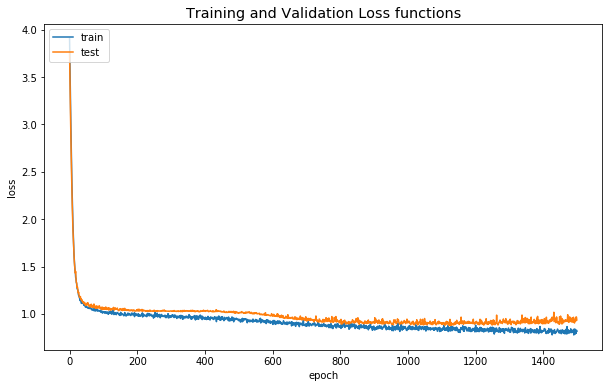

In [22]:
nn_pred = trace_classification.neural_net_classifier(X_train, y_train, X_test, y_test, '3classes', batch_size=32)
nn_results, nn_confusion_matrix = trace_classification.test_metrics('neural network', y_test, nn_pred)
nn_results

### Unsupervised Algorithms

Now we can try to model the problem as an unsupervised learning problem. First, we apply a PCA transformation to collapse the set of datapoints to a 3D space.

In [17]:
X_pca = trace_classification.pca_transformation(X, n_components=len(X.columns)-2)
X_pca.head()

,0,1,2,3,4,5,6
0,-0.668204,0.110733,0.018614,0.036408,-0.024078,-0.000024,-0.019151
1,0.056426,0.133151,0.237047,0.124811,-0.025002,-0.002915,0.024711
2,-0.153224,0.137962,0.179721,-0.095253,0.109158,0.038978,0.011213
3,-0.485907,-0.144048,-0.093764,0.008906,-0.023902,0.024285,0.001100
4,0.636964,-0.158631,0.174407,-0.069568,0.073849,0.016118,0.001282


5. Let us try modeling the problem with **K-Means**.

,model,accuracy,precision,recall,f1-score,auc roc
0,kmeans,0.382353,0.399226,0.380536,0.383927,0.532151


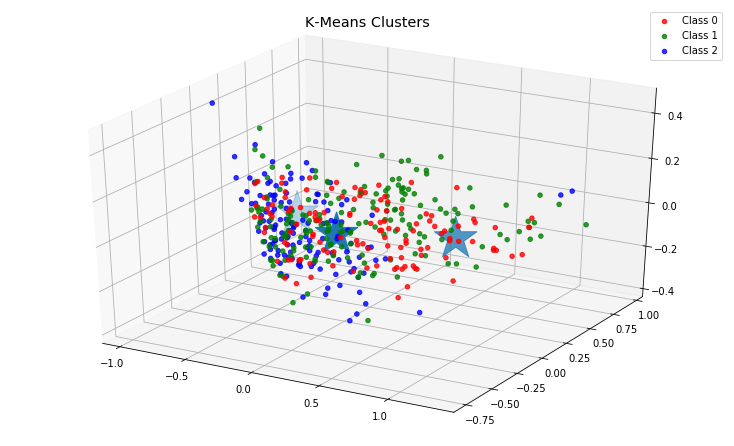

In [23]:
kmeans_pred, centroids = trace_classification.kmeans_classifier(X_pca, n_clusters=3)
data_visualization.plot_3d_points(X_pca[0], X_pca[1], X_pca[3], y, plot_name='KMeans_K3', centroids=centroids)
kmeans_results, kmeans_confusion_matrix = trace_classification.test_metrics('kmeans', y, kmeans_pred)
kmeans_results

## Conclusions

Let us compare the results obtained from the experiment.

In [24]:
trace_classification.write_results([knn_results, rfc_results, svm_results, nn_results, kmeans_results], list(X.columns.values), 3)

,model,n_classes,accuracy,precision,recall,f1-score,auc roc,features
0,knn,3,0.494382,0.496991,0.503968,0.495420,0.625899,"hop, loss, max, mean, min, outliers, pckt_coun..."
1,random forest,3,0.516854,0.531391,0.501190,0.507488,0.627813,"hop, loss, max, mean, min, outliers, pckt_coun..."
2,svm,3,0.595506,0.608135,0.576984,0.580939,0.683654,"hop, loss, max, mean, min, outliers, pckt_coun..."
3,neural network,3,0.629213,0.677438,0.603968,0.610746,0.704054,"hop, loss, max, mean, min, outliers, pckt_coun..."
4,kmeans,3,0.382353,0.399226,0.380536,0.383927,0.532151,"hop, loss, max, mean, min, outliers, pckt_coun..."


In this case, the **neural network** still performs good, folloed by **svm**.

# References

1. *Deep Learning for Detection of Routing Attacks in the Internet of Things*, International Journal of Computational Intelligence Systems (2018), by Furkan Yusuf Yavuz, Devrim Ünal and Ensar Gul
2. *Machine Learning in IoT Security:Current Solutions and Future Challenges*, arXiv:1904.05735v1 (Mar 2019), by Fatima Hussain, Rasheed Hussain, Syed Ali Hassan, and Ekram Hossain.
3. *Almost Everything You Need to Know About Time Series*, https://towardsdatascience.com/almost-everything-you-need-to-know-about-time-series-860241bdc578, by Marco Peixeiro
4. *How to Check if Time Series Data is Stationary with Python*, https://machinelearningmastery.com/time-series-data-stationary-python/, by Jason Brownlee
5. *K-Means Clustering in Python*, https://mubaris.com/posts/kmeans-clustering/, by Mubaris NK
6. *AUC ROC Curve Scoring Function for Multi-class Classification*, https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659, by Eric Plog